# Brain Tumor Classification

In this notebook, I'll be going through step by step on how we can develop a model for unstructured data like images. Since our data is non-tabular, a neural network would be more suitable to handle the data. We will try to train our own model first , then try implementing a transfer learning based approach later! I will also be implementing feature engineering as inspired by Ruslan Klymentiev in his kaggle notebook [https://www.kaggle.com/code/ruslankl/brain-tumor-detection-v1-0-cnn-vgg-16]


## Exploratory Data Analysis

In [13]:
# First let's unzip the file


# importing the zipfile module 
#from zipfile import ZipFile 
  
# loading the temp.zip and creating a zip object 
#with ZipFile("./Brain-Tumor-Files.zip", 'r') as zObject: 
  
    # Extracting all the members of the zip  
    # into a specific location. 
    #zObject.extractall() 

What we have for data is a bunch of images of cases where there is a brain tumor (y=1) and there isn't a brain tumor (y=0). What we'll first do is plot a single instance of the data

In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.preprocessing.image import  ImageDataGenerator as Imgen
from tqdm import tqdm
import os
import cv2

In [4]:
def load_data(dir_path, img_size=(100, 100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []  # List to store images
    y = []  # List to store corresponding labels
    i = 0    # Counter for labels
    labels = dict()  # Dictionary to map labels to indices

    # Loop through each subdirectory in the specified directory
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path  # Map index 'i' to the label 'path'
            
            # Loop through each file in the subdirectory
            for file in os.listdir(os.path.join(dir_path, path)):
                if not file.startswith('.'):
                    # Read, resize, and append the image to the list 'X'
                    img_path = os.path.join(dir_path, path, file)
                    img = cv2.imread(img_path)
                    img = cv2.resize(img, img_size)  # Resize the image
                    X.append(img)
                    
                    # Append the corresponding label index 'i' to the list 'y'
                    y.append(i)
            i += 1

    # Convert lists 'X' and 'y' to NumPy arrays
    X = np.array(X)
    y = np.array(y)

    # Print information about the loaded images
    print(f'{len(X)} images loaded from {dir_path} directory.')

    # Return the image data (X), labels (y), and a dictionary mapping indices to labels
    return X, y, labels

# Add this line to ensure the function returns values
x, y, labels = load_data("./brain_tumor_dataset/", img_size=(224, 224))

100%|██████████| 2/2 [00:00<00:00,  4.66it/s]

253 images loaded from ./brain_tumor_dataset/ directory.


In [5]:
x, y, label = load_data("./brain_tumor_dataset/", img_size=(224,224))

100%|██████████| 2/2 [00:00<00:00,  4.81it/s]

253 images loaded from ./brain_tumor_dataset/ directory.


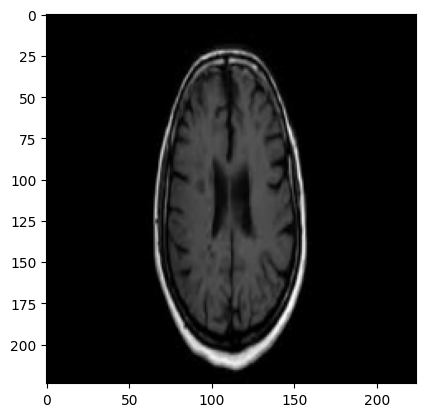

In [40]:
plt.imshow(x[2])

What I want to do next is to create a basic Convolutional Neural Network (CNN) which I'll use as a baseline model to see how the model changes when we do feature engineering. 

In [14]:
# TESTING CELL
import os
from sklearn.model_selection import train_test_split
from shutil import copyfile

# Define the root directory containing subdirectories for each class
root_directory = './brain_tumor_dataset/'

# Define the output directories for train and test sets
output_directory = '../Tumor-Classification/'

# Get a list of all class directories
class_directories = [os.path.join(root_directory, d) for d in os.listdir(root_directory) if os.path.isdir(os.path.join(root_directory, d))]

# Loop through each class directory and split into train and test sets
for class_dir in class_directories:
    class_name = os.path.basename(class_dir)
    
    # Get a list of all images in the class directory
    images = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.endswith(('.jpg', '.png'))]
    
    # Split the images into train and test sets
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
    
    # Create output directories for train and test sets
    train_class_dir = os.path.join(output_directory, 'train', class_name)
    test_class_dir = os.path.join(output_directory, 'test', class_name)
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)
    
    # Copy images to train directory
    for train_img in train_images:
        copyfile(train_img, os.path.join(train_class_dir, os.path.basename(train_img)))
    
    # Copy images to test directory
    for test_img in test_images:
        copyfile(test_img, os.path.join(test_class_dir, os.path.basename(test_img)))


In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define directories for your training and validation datasets
train_dir = './train/'

# Define image dimensions and batch size
img_width, img_height = 150, 150
batch_size = 32

# Create data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

# Create a simple CNN model
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=30
)

# Save the trained model
# model.save('../Tumor-Classification/')


Found 137 images belonging to 2 classes.


Epoch 1/30
4/4 [==============================] - 3s 447ms/step - loss: 1.4530 - accuracy: 0.6381
Epoch 2/30
4/4 [==============================] - 2s 430ms/step - loss: 0.7373 - accuracy: 0.4952
Epoch 3/30
4/4 [==============================] - 2s 460ms/step - loss: 0.6894 - accuracy: 0.5524
Epoch 4/30
4/4 [==============================] - 2s 413ms/step - loss: 0.6671 - accuracy: 0.5714
Epoch 5/30
4/4 [==============================] - 2s 438ms/step - loss: 0.6680 - accuracy: 0.6571
Epoch 6/30
4/4 [==============================] - 2s 562ms/step - loss: 0.6218 - accuracy: 0.6667
Epoch 7/30
4/4 [==============================] - 2s 575ms/step - loss: 0.7110 - accuracy: 0.6476
Epoch 8/30
4/4 [==============================] - 3s 627ms/step - loss: 0.6330 - accuracy: 0.6797
Epoch 9/30
4/4 [==============================] - 2s 511ms/step - loss: 0.6186 - accuracy: 0.6797
Epoch 10/30
4/4 [==============================] - 2s 398ms/step - loss: 0.5998 - accuracy: 0.6571
Epoch 11/30
4/4 [==

In [3]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 17, 17, 128)      

In [10]:
from tensorflow.keras.preprocessing import image

# Load and preprocess a new image for prediction
new_image_path = './test/no/10 no.jpg'


img = image.load_img(new_image_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Rescale pixel values to [0, 1]

# Make a prediction
prediction = model.predict(img_array)

# Print the prediction
if prediction[0][0] > 0.5:
    print("The image is in the positive class (Class 1).")
else:
    print("The image is in the negative class (Class 0).")

1/1 [==============================] - 0s 126ms/step
The image is in the negative class (Class 0).


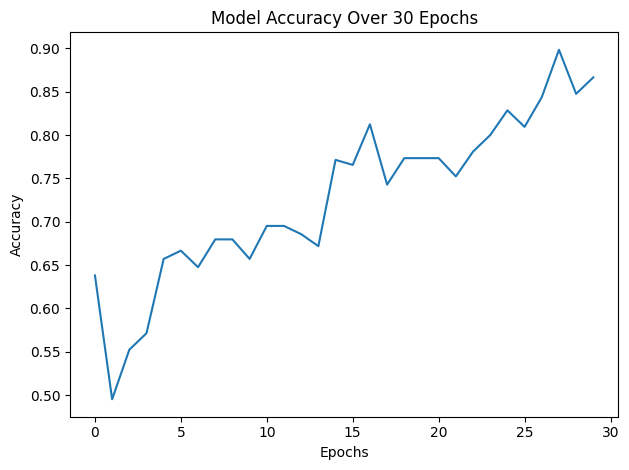

In [13]:
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy Over 30 Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

In [26]:
from keras.utils import load_img, img_to_array
from skimage.transform import resize

test_img = load_img('./test/no/10 no.jpg')
test_img_array = img_to_array(test_img)
temp = resize(test_img_array, (150,150))
temp = np.expand_dims(temp, axis=0)
temp.shape

model.predict(temp)

1/1 [==============================] - 0s 177ms/step


array([[1.]], dtype=float32)

In [32]:
def preprocess_images(image_paths, target_size=(150, 150)):
    images = []
    for image_path in image_paths:
        img = load_img(image_path)
        img_array = img_to_array(img)
        img_array = resize(img_array, target_size)
        images.append(img_array)
    return np.array(images)

# Directory containing your images
directory_path = './test/no/'

# Get the list of filenames in the directory
image_filenames = os.listdir(directory_path)

# Create full paths to the images
image_paths = [os.path.join(directory_path, filename) for filename in image_filenames]


# Preprocess the images
preprocessed_images = preprocess_images(image_paths)

# Make predictions
no_predictions = model.predict(preprocessed_images)

# Print predictions or further processing
for image_path, prediction in zip(image_paths, no_predictions):
    print(f"Image: {image_path}, Prediction: {prediction}")

1/1 [==============================] - 0s 95ms/step
Image: ./test/no/10 no.jpg, Prediction: [1.]
Image: ./test/no/14 no.jpg, Prediction: [0.]
Image: ./test/no/21 no.jpg, Prediction: [0.]
Image: ./test/no/23 no.jpg, Prediction: [0.]
Image: ./test/no/29 no.jpg, Prediction: [0.]
Image: ./test/no/32 no.jpg, Prediction: [0.]
Image: ./test/no/42 no.jpg, Prediction: [0.]
Image: ./test/no/N6.jpg, Prediction: [1.]
Image: ./test/no/no 100.jpg, Prediction: [1.]
Image: ./test/no/no 8.jpg, Prediction: [0.]
Image: ./test/no/no 89.jpg, Prediction: [0.]
Image: ./test/no/no 90.jpg, Prediction: [0.]
Image: ./test/no/no 923.jpg, Prediction: [0.]
Image: ./test/no/no 94.jpg, Prediction: [0.]
Image: ./test/no/no 97.jpg, Prediction: [0.]
Image: ./test/no/no.jpg, Prediction: [3.806592e-12]
Image: ./test/no/No12.jpg, Prediction: [0.]
Image: ./test/no/No15.jpg, Prediction: [0.]


In [38]:
# Print number of predictions the model got right and got wrong at a threshold of 0.5
correct = 0
incorrect = 0
classification_threshold = 0.5
for prediction in no_predictions:
    if prediction[0] > classification_threshold:
        incorrect += 1
    else:
        correct += 1

print(f'Correct 0 Classification: {correct} | Incorrect 0 Classification: {incorrect} | At classification threshold {classification_threshold}')
print(f'Accuracy: {correct / (correct + incorrect)}')

Correct 0 Classification: 15 | Incorrect 0 Classification: 3 | At classification threshold 0.5
Accuracy: 0.8333333333333334


In [31]:
# Directory containing your images
directory_path = './test/yes/'

# Get the list of filenames in the directory
image_filenames = os.listdir(directory_path)

# Create full paths to the images
image_paths = [os.path.join(directory_path, filename) for filename in image_filenames]


# Preprocess the images
preprocessed_images = preprocess_images(image_paths)

# Make predictions
yes_predictions = model.predict(preprocessed_images)

# Print predictions or further processing
for image_path, prediction in zip(image_paths, yes_predictions):
    print(f"Image: {image_path}, Prediction: {prediction}")

1/1 [==============================] - 0s 98ms/step
Image: ./test/yes/Y1.jpg, Prediction: [1.]
Image: ./test/yes/Y103.jpg, Prediction: [1.]
Image: ./test/yes/Y11.jpg, Prediction: [1.]
Image: ./test/yes/Y13.jpg, Prediction: [1.]
Image: ./test/yes/Y168.jpg, Prediction: [1.]
Image: ./test/yes/Y181.jpg, Prediction: [1.]
Image: ./test/yes/Y187.jpg, Prediction: [0.]
Image: ./test/yes/Y24.jpg, Prediction: [1.]
Image: ./test/yes/Y39.jpg, Prediction: [1.]
Image: ./test/yes/Y6.jpg, Prediction: [1.]
Image: ./test/yes/Y60.jpg, Prediction: [1.]
Image: ./test/yes/Y62.jpg, Prediction: [1.]
Image: ./test/yes/Y69.jpg, Prediction: [1.]
Image: ./test/yes/Y79.jpg, Prediction: [1.]
Image: ./test/yes/Y82.jpg, Prediction: [1.]
Image: ./test/yes/Y9.jpg, Prediction: [1.]
Image: ./test/yes/Y92.jpg, Prediction: [1.]
Image: ./test/yes/Y92.png, Prediction: [1.]


It looks like our model does better at predicting when there is a tumor than when there isn't. In the context of brain tumors, I think it would be to "safer" to have more false positives. Generally I'd say the model is doing well but it can definitely do better. Let's see what kind of data augmentation we can do to improve accuracy. On top of that, we'll also try using the VGG16 model to see how transfer learning works.